# Feature engineering on extracted Pull Requests data


## What we did previously

In the previous [notebook](./01_data_collection.ipynb) we collected data from a Github repository of choice and store them on S3 storage

## In this step

In this notebook we will walk through how to start analyzing the PR data collected from a Github repository.

We explore the various fields in the PR dataset and the features that we can derive from them in order to frame an a Machine Learning where we predict the time taken to merge a PR.

In [1]:
import os
import math
import re
import gzip
import json
import boto3
import trino
import pathlib
import datetime
from tqdm import tqdm
from io import BytesIO
from pathlib import Path
from functools import partial
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif, f_classif

from dotenv import load_dotenv, find_dotenv

In [2]:
class CephCommunication:
    """
    Class to establish communication with a ceph s3 bucket.
    It connects with the bucket and provides methods to read and write data in the parquet format.
    """

    def __init__(
        self, s3_endpoint_url, aws_access_key_id, aws_secret_access_key, s3_bucket
    ):
        self.s3_endpoint_url = s3_endpoint_url
        self.aws_access_key_id = aws_access_key_id
        self.aws_secret_access_key = aws_secret_access_key
        self.s3_resource = boto3.resource(
            "s3",
            endpoint_url=self.s3_endpoint_url,
            aws_access_key_id=self.aws_access_key_id,
            aws_secret_access_key=self.aws_secret_access_key,
        )
        self.bucket = s3_bucket
        ## Todo: Add try catch

    def upload_to_ceph(self, dataframe, s3_path, filename):
        """
        This helper function takes as input the data frame to be uploaded, and the output filename.
        It then saves the data frame in the defined ceph bucket.
        """
        parquet_buffer = BytesIO()
        dataframe.to_parquet(parquet_buffer)
        s3_obj = self.s3_resource.Object(self.bucket, f"{s3_path}/{filename}")
        status = s3_obj.put(Body=parquet_buffer.getvalue())
        return status

    def read_from_ceph(self, s3_path, filename):
        """
        Helper function to read from ceph and see if the saved data is correct.
        """
        buffer = BytesIO()
        s3_object = self.s3_resource.Object(self.bucket, f"{s3_path}/{filename}")
        s3_object.download_fileobj(buffer)
        df_temp = pd.read_parquet(buffer)
        return df_temp


def save_to_disk(dataframe, path, filename):
    """
    Helper function to save the dataframe
    as a parquet file to disk.
    """
    dataset_base_path = Path(path)
    dataset_base_path.mkdir(parents=True, exist_ok=True)
    dataframe.to_parquet(f"{path}/{filename}")
    return True

In [3]:
sns.set(rc={"figure.figsize": (20, 10)})
load_dotenv(find_dotenv(), override=True)

True

In [4]:
## CEPH Bucket variables
## Create a .env file on your local with the correct configs,

ORG = os.getenv("GITHUB_ORG")
REPO = os.getenv("GITHUB_REPO")

## S3 bucket credentials
s3_endpoint_url = os.getenv("S3_ENDPOINT_URL")
s3_access_key = os.getenv("AWS_ACCESS_KEY_ID")
s3_secret_key = os.getenv("AWS_SECRET_ACCESS_KEY")
s3_bucket = os.getenv("S3_BUCKET")

REMOTE = os.getenv("REMOTE")

s3_input_data_path = os.getenv("CEPH_BUCKET_PREFIX")
local_input_data_path = "../../../data/raw/GitHub/PullRequest.json.gz"
local_output_data_path = "../../../data/processed/github"
RAW_DATA_PATH = os.path.join(
    s3_input_data_path, "srcopsmetrics/bot_knowledge", ORG, REPO, "PullRequest.json"
)

## Trino
SQL_TABLE_FILENAME = os.path.join(ORG + REPO + "prs.parquet")
SQL_TABLE_KEY = os.path.join(s3_input_data_path, ORG, REPO, "sql")

In [5]:
output = []
if REMOTE:
    print("getting dataset from ceph")
    s3 = boto3.resource(
        "s3",
        endpoint_url=s3_endpoint_url,
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
    )
    content = s3.Object(s3_bucket, RAW_DATA_PATH)
    file = content.get()["Body"].read().decode("utf-8")

    prs = json.loads(file)

    for pr in prs.splitlines():
        output.append(json.loads(pr))

else:
    print("getting dataset from local")
    with gzip.open(local_input_data_path, "r") as f:
        prs = json.loads(f.read().decode("utf-8"))

pr_df = pd.DataFrame(output)

getting dataset from ceph


In [6]:
pr_df

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,id
0,Added endpoint to deployment file,None,XS,suppathak,1658510693,1.658515e+09,sesheta,1.658515e+09,sesheta,1,1,{'sesheta': 65},"{'1048203683': {'author': 'oindrillac', 'words...","[approved, size/XS, lgtm]",[1037904625e547a5f3d6dfdd3b43782524e31272],[notebooks/time-to-merge-prediction/workshop/d...,1.658511e+09,1.658511e+09,554
1,Release of version 0.4.0,"Hey, @aakankshaduggal!\n\nOpening this PR to c...",M,khebhut[bot],1658510357,NaN,None,NaN,None,1,2,"{'sesheta': 202, 'aakankshaduggal': 1}",{},"[bot, size/M, ok-to-test]",[8267aa1c538afe0f6b38ef5ced5e49c4a5370e70],"[CHANGELOG.md, setup.py]",NaN,NaN,553
2,added inference file,closes #529,XXL,oindrillac,1658509819,1.658511e+09,sesheta,1.658511e+09,sesheta,1,4,"{'review-notebook-app[bot]': 29, 'aakankshadug...","{'1048188763': {'author': 'aakankshaduggal', '...","[approved, size/XXL, lgtm]",[16d3be5a45ca1596a2cb572f9c71650a479ed5f4],[notebooks/time-to-merge-prediction/workshop/0...,1.658510e+09,NaN,551
3,Updating pipeline docs for workshop,## Related Issues and Dependencies\r\n #540,XS,suppathak,1658499144,1.658513e+09,sesheta,1.658513e+09,sesheta,2,9,"{'oindrillac': 65, 'sesheta': 68}","{'1048107139': {'author': 'oindrillac', 'words...","[approved, size/XS, lgtm]","[41f713d5dedc1acbf23321ed0995c6e06a9b79d2, 7d3...",[docs/assets/images/ml-pipeline-completed-pipe...,1.658506e+09,1.658508e+09,550
4,Modified Model-deployment files for workshop,\r\nRelated #540 \r\n,S,suppathak,1658494681,1.658506e+09,sesheta,1.658506e+09,sesheta,1,4,{'sesheta': 65},"{'1047883840': {'author': 'oindrillac', 'words...","[approved, size/S, lgtm]",[0d58fc20be7b79f3c8e85144616e96670b43642a],"[docs/assets/images/deployment-config1.png, do...",1.658495e+09,1.658506e+09,549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,Initial EDA on testgrid data,As part of issue #15 this PR includes an init...,XXL,MichaelClifford,1600204862000,1.600962e+12,aakankshaduggal,1.600962e+12,aakankshaduggal,3,2,{'review-notebook-app[bot]': 29},"{'491646904': {'author': 'aakankshaduggal', 'w...",[],"[b3d6ee6002c302fbcf6dceaa6bbcbca9b2ed4eeb, c23...","[docs/assets/images/testgrid_0.png, notebooks/...",1.600449e+12,1.600449e+12,16
233,[WIP] EDA notebook on sippy ci data,This is currently a work in progress EDA noteb...,XXL,MichaelClifford,1599767752000,1.599816e+12,durandom,1.599816e+12,durandom,1,1,{'review-notebook-app[bot]': 30},"{'486646627': {'author': 'durandom', 'words_co...",[],[fd9426c955ae258a253f6011980c0a6c56730497],[notebooks/EDA.ipynb],1.599816e+12,1.599816e+12,14
234,Add url of job runs where failures occur toget...,"This PR contains 2 main changes. 1st, an addit...",XL,MichaelClifford,1598542192000,1.598968e+12,durandom,1.598968e+12,durandom,3,2,{'review-notebook-app[bot]': 30},"{'477563575': {'author': 'durandom', 'words_co...",[],"[6f9b535b0064a0b319032b174bf2351c4804bff7, 8cb...","[data/interim/correlation_sets.csv, notebooks/...",1.598605e+12,1.598968e+12,9
235,Update notebook for better readability,Added fixes for better readability as suggeste...,XL,MichaelClifford,1598452490000,1.598533e+12,durandom,1.598533e+12,durandom,1,1,"{'review-notebook-app[bot]': 30, 'MichaelCliff...",{},[],[d233d66ab8bdfee5a9bbb805a59b8cedb4d2383c],[notebooks/initial_EDA.ipynb],NaN,NaN,6


In [7]:
pr_df.shape

(237, 19)

In [8]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,id
0,Added endpoint to deployment file,None,XS,suppathak,1658510693,1.658515e+09,sesheta,1.658515e+09,sesheta,1,1,{'sesheta': 65},"{'1048203683': {'author': 'oindrillac', 'words...","[approved, size/XS, lgtm]",[1037904625e547a5f3d6dfdd3b43782524e31272],[notebooks/time-to-merge-prediction/workshop/d...,1.658511e+09,1.658511e+09,554
1,Release of version 0.4.0,"Hey, @aakankshaduggal!\n\nOpening this PR to c...",M,khebhut[bot],1658510357,NaN,None,NaN,None,1,2,"{'sesheta': 202, 'aakankshaduggal': 1}",{},"[bot, size/M, ok-to-test]",[8267aa1c538afe0f6b38ef5ced5e49c4a5370e70],"[CHANGELOG.md, setup.py]",NaN,NaN,553


## Inspect the dataset

Let's unroll a single row and see what kind of information we have access to. 

In [9]:
pr = pr_df.iloc[10]
pr

title                          fixed more html files with merge conflicts
body                    https://aicoe-aiops.github.io/ocp-ci-analysis/...
size                                                                   XL
created_by                                                     oindrillac
created_at                                                  1658345811000
closed_at                                                 1658347120000.0
closed_by                                                 aakankshaduggal
merged_at                                                 1658347120000.0
merged_by                                                 aakankshaduggal
commits_number                                                          1
changed_files_number                                                    3
interactions            {'sesheta': 56, 'aakankshaduggal': 17, 'oindri...
reviews                 {'1045602905': {'author': 'aakankshaduggal', '...
labels                                

</br>

#### **Available Fields**

* **title**: text providing a short description of the of the PR.

* **body**: text providing additional details regarding the changes. 

* **size**: categorical label generated by GitHub summerizing the size of the changes made to the code base. 

* **created/closed/merged_at**: timestamps for when the PR was opened, merged and finally closed. 

* **created/closed_by**: usernames for contributors who created the PR and closed it. 

* **commits_number**: integer indicating the number of commits in the PR.

* **changed_files_number**: integer indicating the number of files changed.

The remaining fields appear to be collections of items, let's unroll each one and see what additional information they provide.


In [10]:
pr["interactions"]

{'sesheta': 56, 'aakankshaduggal': 17, 'oindrillac': 77}

**interactions**: a dictionary with usernames for keys and the number of times they interacted with the PR as the value.

In [11]:
pr["reviews"]

{'1045602905': {'author': 'aakankshaduggal',
  'words_count': 1,
  'submitted_at': 1658347115,
  'state': 'COMMENTED'}}

**reviews**: a dictionary of reviews that includes an id number key along with fields for author, word_count, submitted timestamp and state of review.

In [12]:
pr["labels"]

['size/XL', 'lgtm']

**labels**: a list of labels tagged to the PR describing some of its attributes

In [13]:
pr["commits"]

['1797b513d1ac3f70b83cf33e7be2dabfdfc1422c']

**commits**: a list of commit hashes that point to specific changes made to the repo's history

In [14]:
print(len(pr["changed_files"]))
pr["changed_files"][0:10]

3


['README.html', 'genindex.html', 'search.html']

**changed_files**: a list of the paths and filenames for every file changed by this PR.

We now know what we have access to in this dataset. It is a collection of numerical, categorical and textual features used to describe a PR. This gives us a lot of potential avenues to explore from an EDA and Data Science perspective. But is also creates an additional challenge insofar as we'll need to do a bit of feature engineering to get this data into format that is ready to be ingested by any ML models. 

## Feature engineering

In the next section we will do some basic feature engineering and correlation analyis on our dataset to see if anything interesting jumps out at us. 

**Make time columns uniform**

In [15]:
def time_uniform(col):
    if math.isnan(col):
        return float(col)
    elif len(str(int(col))) == 13:
        col = col / 1000
        return float(col)
    return float(col)

In [16]:
pr_df["created_at"] = pr_df["created_at"].apply(lambda x: time_uniform(x))
pr_df["closed_at"] = pr_df["closed_at"].apply(lambda x: time_uniform(x))
pr_df["merged_at"] = pr_df["merged_at"].apply(lambda x: time_uniform(x))
pr_df["first_review_at"] = pr_df["first_review_at"].apply(lambda x: time_uniform(x))
pr_df["first_approve_at"] = pr_df["first_approve_at"].apply(lambda x: time_uniform(x))

In [17]:
pr_df

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,id
0,Added endpoint to deployment file,None,XS,suppathak,1.658511e+09,1.658515e+09,sesheta,1.658515e+09,sesheta,1,1,{'sesheta': 65},"{'1048203683': {'author': 'oindrillac', 'words...","[approved, size/XS, lgtm]",[1037904625e547a5f3d6dfdd3b43782524e31272],[notebooks/time-to-merge-prediction/workshop/d...,1.658511e+09,1.658511e+09,554
1,Release of version 0.4.0,"Hey, @aakankshaduggal!\n\nOpening this PR to c...",M,khebhut[bot],1.658510e+09,NaN,None,NaN,None,1,2,"{'sesheta': 202, 'aakankshaduggal': 1}",{},"[bot, size/M, ok-to-test]",[8267aa1c538afe0f6b38ef5ced5e49c4a5370e70],"[CHANGELOG.md, setup.py]",NaN,NaN,553
2,added inference file,closes #529,XXL,oindrillac,1.658510e+09,1.658511e+09,sesheta,1.658511e+09,sesheta,1,4,"{'review-notebook-app[bot]': 29, 'aakankshadug...","{'1048188763': {'author': 'aakankshaduggal', '...","[approved, size/XXL, lgtm]",[16d3be5a45ca1596a2cb572f9c71650a479ed5f4],[notebooks/time-to-merge-prediction/workshop/0...,1.658510e+09,NaN,551
3,Updating pipeline docs for workshop,## Related Issues and Dependencies\r\n #540,XS,suppathak,1.658499e+09,1.658513e+09,sesheta,1.658513e+09,sesheta,2,9,"{'oindrillac': 65, 'sesheta': 68}","{'1048107139': {'author': 'oindrillac', 'words...","[approved, size/XS, lgtm]","[41f713d5dedc1acbf23321ed0995c6e06a9b79d2, 7d3...",[docs/assets/images/ml-pipeline-completed-pipe...,1.658506e+09,1.658508e+09,550
4,Modified Model-deployment files for workshop,\r\nRelated #540 \r\n,S,suppathak,1.658495e+09,1.658506e+09,sesheta,1.658506e+09,sesheta,1,4,{'sesheta': 65},"{'1047883840': {'author': 'oindrillac', 'words...","[approved, size/S, lgtm]",[0d58fc20be7b79f3c8e85144616e96670b43642a],"[docs/assets/images/deployment-config1.png, do...",1.658495e+09,1.658506e+09,549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,Initial EDA on testgrid data,As part of issue #15 this PR includes an init...,XXL,MichaelClifford,1.600205e+09,1.600962e+09,aakankshaduggal,1.600962e+09,aakankshaduggal,3,2,{'review-notebook-app[bot]': 29},"{'491646904': {'author': 'aakankshaduggal', 'w...",[],"[b3d6ee6002c302fbcf6dceaa6bbcbca9b2ed4eeb, c23...","[docs/assets/images/testgrid_0.png, notebooks/...",1.600449e+09,1.600449e+09,16
233,[WIP] EDA notebook on sippy ci data,This is currently a work in progress EDA noteb...,XXL,MichaelClifford,1.599768e+09,1.599816e+09,durandom,1.599816e+09,durandom,1,1,{'review-notebook-app[bot]': 30},"{'486646627': {'author': 'durandom', 'words_co...",[],[fd9426c955ae258a253f6011980c0a6c56730497],[notebooks/EDA.ipynb],1.599816e+09,1.599816e+09,14
234,Add url of job runs where failures occur toget...,"This PR contains 2 main changes. 1st, an addit...",XL,MichaelClifford,1.598542e+09,1.598968e+09,durandom,1.598968e+09,durandom,3,2,{'review-notebook-app[bot]': 30},"{'477563575': {'author': 'durandom', 'words_co...",[],"[6f9b535b0064a0b319032b174bf2351c4804bff7, 8cb...","[data/interim/correlation_sets.csv, notebooks/...",1.598605e+09,1.598968e+09,9
235,Update notebook for better readability,Added fixes for better readability as suggeste...,XL,MichaelClifford,1.598452e+09,1.598533e+09,durandom,1.598533e+09,durandom,1,1,"{'review-notebook-app[bot]': 30, 'MichaelCliff...",{},[],[d233d66ab8bdfee5a9bbb805a59b8cedb4d2383c],[notebooks/initial_EDA.ipynb],NaN,NaN,6


In [18]:
pr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 237 non-null    object 
 1   body                  235 non-null    object 
 2   size                  237 non-null    object 
 3   created_by            237 non-null    object 
 4   created_at            237 non-null    float64
 5   closed_at             229 non-null    float64
 6   closed_by             229 non-null    object 
 7   merged_at             223 non-null    float64
 8   merged_by             223 non-null    object 
 9   commits_number        237 non-null    int64  
 10  changed_files_number  237 non-null    int64  
 11  interactions          237 non-null    object 
 12  reviews               237 non-null    object 
 13  labels                237 non-null    object 
 14  commits               237 non-null    object 
 15  changed_files         2

**Time to Merge**

We will derive a new feature called `time_to_merge` which will be the difference between the `created_at` and `merged_at` fields. 

In [19]:
# derive time_to_merege
pr_df["time_to_merge"] = pr_df["merged_at"] - pr_df["created_at"]
pr_df["time_to_merge"] = pr_df["time_to_merge"].astype("float")
# NOTE: we cant fill NA with 0 because that would imply the PR got merged instantaneously

In [20]:
pr_df["time_to_merge"]

0        3949.0
1           NaN
2        1054.0
3       13938.0
4       11264.0
         ...   
232    757448.0
233     48415.0
234    426198.0
235     80593.0
236    705281.0
Name: time_to_merge, Length: 237, dtype: float64

Let's look at the distribution of the time to merge column. This can help us determine what the setup for ML problems such as [#236](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/236) could be like. That is, should the time to merge problem be framed as a regression or classification problem.

First, lets try to determine what the granularity of the output values should be, in case of a regression setup. That is, should the model predict time to merge in number of seconds, number of hours, number of days, or some other chunk of time.

In [21]:
# what does the distribution of values look like if we choose days as the granularity
ttm_days = np.ceil(pr_df.time_to_merge / (60 * 60 * 24))

# value counts - to how many PRs have value 1, 2, 3, etc. for days to merge
vc = ttm_days.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0      0.538117
2.0      0.089686
3.0      0.053812
5.0      0.044843
6.0      0.035874
7.0      0.035874
4.0      0.031390
9.0      0.031390
13.0     0.017937
16.0     0.013453
18.0     0.008969
28.0     0.008969
23.0     0.008969
15.0     0.008969
80.0     0.004484
26.0     0.004484
98.0     0.004484
75.0     0.004484
21.0     0.004484
29.0     0.004484
12.0     0.004484
39.0     0.004484
31.0     0.004484
10.0     0.004484
14.0     0.004484
25.0     0.004484
11.0     0.004484
104.0    0.004484
17.0     0.004484
52.0     0.004484
Name: time_to_merge, dtype: float64

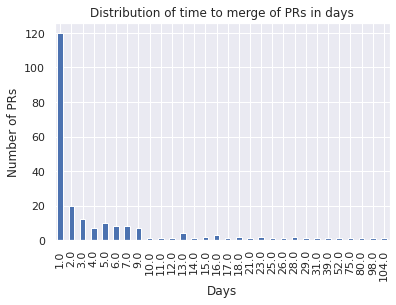

In [22]:
# only plot top 100 values so that graph is legible
vc.sort_index().iloc[:100].plot(kind="bar")
plt.xlabel("Days")
plt.ylabel("Number of PRs")
plt.title("Distribution of time to merge of PRs in days")
plt.show()

In [23]:
# what if we chose some intermediate value e.g. 3 hours as the granularity?
ttm_3hours = np.ceil(pr_df.time_to_merge / (60 * 60 * 3))

# value counts - to how many PRs have value 1, 2, 3, etc. for num. 3-hours to merge
vc = ttm_3hours.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0      0.327354
8.0      0.062780
7.0      0.062780
2.0      0.031390
9.0      0.031390
           ...   
634.0    0.004484
103.0    0.004484
226.0    0.004484
49.0     0.004484
66.0     0.004484
Name: time_to_merge, Length: 73, dtype: float64

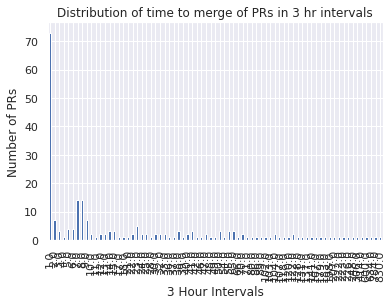

In [24]:
# only plot top 100 values so that graph is legible
vc.sort_index().iloc[:100].plot(kind="bar")
plt.xlabel("3 Hour Intervals")
plt.ylabel("Number of PRs")
plt.title("Distribution of time to merge of PRs in 3 hr intervals")
plt.show()

In [25]:
# what if we chose hours as the granularity?
ttm_hours = np.ceil(pr_df.time_to_merge / (60 * 60))

# value counts - to how many PRs have value 1, 2, 3, etc. for hours to merge
vc = ttm_hours.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0      0.188341
2.0      0.103139
19.0     0.040359
3.0      0.035874
20.0     0.022422
           ...   
410.0    0.004484
742.0    0.004484
240.0    0.004484
319.0    0.004484
196.0    0.004484
Name: time_to_merge, Length: 104, dtype: float64

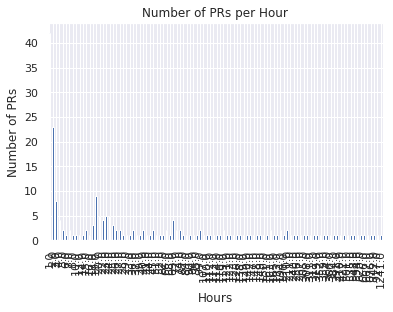

In [26]:
# only plot top 100 values so that graph is legible
vc.sort_index().iloc[:100].plot(kind="bar")
plt.xlabel("Hours")
plt.ylabel("Number of PRs")
plt.title("Number of PRs per Hour")
plt.show()

Now, lets try to determine, if we were to set this up as a classification problem, what the output classes should be. In the following cell, we'll try to split the time-to-merge values into 10 equally populated buckets.

In [27]:
# lets look at what the 10th, 20th, 30th etc percentiles are, to see what the bin boundaries (in terms of hours)
# would be if we were to split the data in 10 equally populated bins
n_buckets = 10

quantiles = pr_df.time_to_merge.quantile(q=np.arange(0, 1 + 1e-100, 1 / n_buckets))
quantiles / 3600

0.0      0.033333
0.1      0.400056
0.2      1.113500
0.3      2.147389
0.4     16.083500
0.5     22.226944
0.6     38.615167
0.7     88.803556
0.8    147.368333
0.9    344.856278
Name: time_to_merge, dtype: float64

In [28]:
intervals = quantiles

In [29]:
# gaps between the buckets (i.e. size of each bucket) in hours
(quantiles - quantiles.shift()) / 3600

0.0           NaN
0.1      0.366722
0.2      0.713444
0.3      1.033889
0.4     13.936111
0.5      6.143444
0.6     16.388222
0.7     50.188389
0.8     58.564778
0.9    197.487944
Name: time_to_merge, dtype: float64

If we want to frame our ML problem as a classification problem, we can use the above buckets to define the classes.

**Body**

Here, we will derive a feature called `body_size` which will simply be the number of words in the body of the PR. We can use this numerical value to describe the body of the PR.

In [30]:
# derive body_size
pr_df["body_size"] = pr_df["body"].fillna("").apply(lambda x: len(x.split()))

In [31]:
pr_df["body_size"]

0        0
1      237
2        2
3        6
4        2
      ... 
232     57
233     46
234     39
235     69
236     28
Name: body_size, Length: 237, dtype: int64

**Size**

We can attempt to convert the categorical size label generated by GitHub, which summarizes the size of the changes made to the code base, to a numerical value. 

In [32]:
set(pr_df["size"])

{'L', 'M', 'NaN', 'S', 'XL', 'XS', 'XXL'}

In [33]:
convert_size = {"size": {"NaN": 0, "XS": 0, "S": 1, "M": 2, "L": 3, "XL": 4, "XXL": 5}}
pr_df = pr_df.replace(convert_size)

**Title**

Lets try to see if the PR title text can be used to extract any useful information regarding the PR.

In [34]:
# first lets preprocess the text available in the titles

# convert to lowercase
preproc_titles = pr_df["title"].str.lower()

# remove punctuations and symbols like : ; , # ( ) [ ] etc
preproc_titles = preproc_titles.str.replace(r'[`#-.?!,:;\/()\[\]"\']', " ", regex=True)

# remove hash-like strings i.e. 25+ char long strings containing 0-9 or a-f
preproc_titles = preproc_titles.str.replace(r"[0-9a-f]{25,}", " ", regex=True)

preproc_titles

0                      added endpoint to deployment file
1                               release of version 0 4 0
2                                   added inference file
3                    updating pipeline docs for workshop
4           modified model deployment files for workshop
                             ...                        
232                         initial eda on testgrid data
233                   wip  eda notebook on sippy ci data
234    add url of job runs where failures occur toget...
235               update notebook for better readability
236                                 initial eda notebook
Name: title, Length: 237, dtype: object

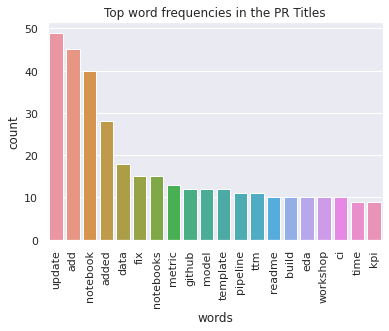

In [35]:
# what are the most commonly appearing words in the titles

# combin all titles and split into words
words = preproc_titles.str.cat(sep=" ").split()

# remove stopwords and numbers (e.g. bugzilla ids)
words = [w for w in words if w not in set(STOPWORDS) and not w.isnumeric()]

# word frequencies
unique_words, counts = np.unique(words, return_counts=True)
vc = pd.Series(counts, index=unique_words).sort_values(ascending=False)

# plot the 20 most common words
sns.barplot(
    x=vc.index[:20],
    y=vc.values[:20],
)
plt.xticks(rotation=90)
plt.title("Top word frequencies in the PR Titles")
plt.xlabel("words")
plt.ylabel("count")
plt.show()

From the above graph, we can see that titles often contain some keywords that can hint towards the type of changes being made in the PR. We will create a feature which is a vector indicating how many times each word appeared in the title. This way, even if a less prominent word is more correlated with time_to_merge, we will be able to capture that relationship.

In [36]:
# add word count columns
for word in tqdm(unique_words):
    pr_df[f"title_wordcount_{word}"] = preproc_titles.apply(
        lambda x: x.split().count(word)
    )

  0%|          | 0/436 [00:00<?, ?it/s]/tmp/ipykernel_2263/4191214648.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pr_df[f"title_wordcount_{word}"] = preproc_titles.apply(
 22%|██▏       | 97/436 [00:00<00:01, 285.75it/s]/tmp/ipykernel_2263/4191214648.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pr_df[f"title_wordcount_{word}"] = preproc_titles.apply(
/tmp/ipykernel_2263/4191214648.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

In [37]:
# collapse the high dim vector into one column
wordcount_columns = [c for c in pr_df.columns if "wordcount" in c]
pr_df["title_word_counts_vec"] = pr_df[wordcount_columns].apply(
    lambda x: x.tolist(), axis=1
)

# drop the individual wordcount columns
pr_df = pr_df.drop(columns=wordcount_columns)

**Created At**

This column can give us information on when the PR was created. Using the `created_at` field, we can derive other features like `time_of_day`, `day_of_week`, `day_of_month`, `month_in_year` each of which can be categorical features that can be useful to our analysis.

In [38]:
pr_df["created_at"]

0      1.658511e+09
1      1.658510e+09
2      1.658510e+09
3      1.658499e+09
4      1.658495e+09
           ...     
232    1.600205e+09
233    1.599768e+09
234    1.598542e+09
235    1.598452e+09
236    1.597159e+09
Name: created_at, Length: 237, dtype: float64

In [39]:
# convert to datetime object
pr_df["created_at_datetime"] = (
    pr_df["created_at"].fillna("").apply(lambda x: datetime.datetime.fromtimestamp(x))
)
# get day as categorical variable
pr_df["created_at_day"] = pr_df["created_at_datetime"].apply(lambda x: x.day)

# get month as categorical variable
pr_df["created_at_month"] = pr_df["created_at_datetime"].apply(lambda x: x.month)

# get weekday as categorical variable
pr_df["created_at_weekday"] = pr_df["created_at_datetime"].apply(lambda x: x.weekday())

# get hour of day as categorical variable
pr_df["created_at_hour"] = pr_df["created_at_datetime"].apply(lambda x: x.hour)

In [40]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,...,first_approve_at,id,time_to_merge,body_size,title_word_counts_vec,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour
0,Added endpoint to deployment file,None,0,suppathak,1.658511e+09,1.658515e+09,sesheta,1.658515e+09,sesheta,1,...,1.658511e+09,554,3949.0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",2022-07-22 17:24:53,22,7,4,17
1,Release of version 0.4.0,"Hey, @aakankshaduggal!\n\nOpening this PR to c...",2,khebhut[bot],1.658510e+09,NaN,None,NaN,None,1,...,NaN,553,NaN,237,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-07-22 17:19:17,22,7,4,17


**Commits Number**  
Commits Number gives the number of commits created within the PR. This could be a numerical feature for our model.

In [41]:
pr_df.commits_number.value_counts()

1     213
2      15
3       4
26      1
5       1
7       1
0       1
50      1
Name: commits_number, dtype: int64

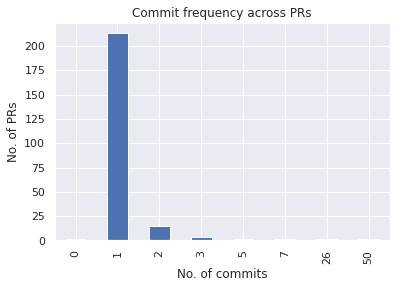

In [42]:
pr_df.commits_number.value_counts().sort_index(ascending=True).plot(kind="bar")
plt.title("Commit frequency across PRs")
plt.xlabel("No. of commits")
plt.ylabel("No. of PRs")
plt.show()

In [43]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,...,first_approve_at,id,time_to_merge,body_size,title_word_counts_vec,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour
0,Added endpoint to deployment file,None,0,suppathak,1.658511e+09,1.658515e+09,sesheta,1.658515e+09,sesheta,1,...,1.658511e+09,554,3949.0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",2022-07-22 17:24:53,22,7,4,17
1,Release of version 0.4.0,"Hey, @aakankshaduggal!\n\nOpening this PR to c...",2,khebhut[bot],1.658510e+09,NaN,None,NaN,None,1,...,NaN,553,NaN,237,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-07-22 17:19:17,22,7,4,17


**Changed Files Number**  
Changed files is a numberical variable which captures the numer of files that were modified in the PR.

In [44]:
# convert changed_files_number to int
pr_df["changed_files_number"] = pr_df["changed_files_number"].astype("int")

pr_df.changed_files_number.value_counts()

1       127
2        35
4        21
3        20
5         9
7         5
9         3
8         3
6         2
15        2
10        2
1427      1
86        1
11        1
16        1
12        1
13        1
0         1
38        1
Name: changed_files_number, dtype: int64

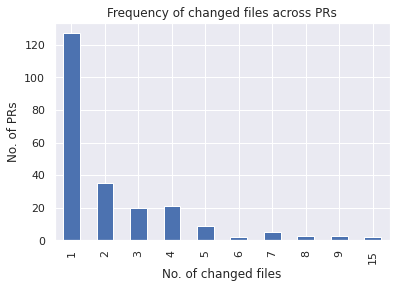

In [45]:
pr_df.changed_files_number.value_counts().iloc[:10].sort_index(ascending=True).plot(
    kind="bar"
)
plt.title("Frequency of changed files across PRs")
plt.xlabel("No. of changed files")
plt.ylabel("No. of PRs")
plt.show()

`changed_files_number` has more variability than the `commits_number`. We can incorporate this as a numerical feature.

**Changed_files**

`changed_files` is a list of the paths and filenames for every file changed by this PR. From `changed_files`, we know, for each PR, which file types were changed which can be encoded as a frequency vector. Also we know which directory the change is made in, so that can be encoded as a categorical variable.

In [46]:
pr_df.changed_files

0      [notebooks/time-to-merge-prediction/workshop/d...
1                               [CHANGELOG.md, setup.py]
2      [notebooks/time-to-merge-prediction/workshop/0...
3      [docs/assets/images/ml-pipeline-completed-pipe...
4      [docs/assets/images/deployment-config1.png, do...
                             ...                        
232    [docs/assets/images/testgrid_0.png, notebooks/...
233                                [notebooks/EDA.ipynb]
234    [data/interim/correlation_sets.csv, notebooks/...
235                        [notebooks/initial_EDA.ipynb]
236                        [notebooks/initial_EDA.ipynb]
Name: changed_files, Length: 237, dtype: object

In [47]:
def filetype(filepath):

    # if standard file extension, return file extension
    if pathlib.Path(filepath).suffix:
        return pathlib.Path(filepath).suffix

    else:
        # if single file at the root of repo
        if "/" not in filepath:
            # if a file like README/Dockerfile etc
            if "." not in filepath:
                return filepath
        # if file not at root
        else:
            # get file name
            file = filepath.rsplit("/", 1)[1]
            if "." not in file:
                return file
            elif "." in file:
                return "." + file.rsplit(".", 1)[1]

In [48]:
# get list of all file types that were modified across all openshift origin PRs
changed_files = list(pr_df["changed_files"])

In [49]:
all_changed_files = [filetype(filepath) for pr in changed_files for filepath in pr]

In [50]:
count = Counter(all_changed_files)

In [51]:
# save 100 most commonly occuring file extensions across PRs
top_fileextensions_freq = count.most_common(100)
top_fileextensions = [ext[0] for ext in top_fileextensions_freq]

In [52]:
top_fileextensions

['.png',
 '.ipynb',
 '.html',
 '.md',
 '.po',
 '.py',
 '.doctree',
 '.yaml',
 '.js',
 '.lock',
 '.css',
 'Pipfile',
 '.svg',
 '.txt',
 '.pipeline',
 '.mdx',
 '.yml',
 'environment',
 '.json',
 'OWNERS',
 None,
 '.csv',
 '.gz',
 '.eot',
 '.ttf',
 '.woff',
 '.woff2',
 '.rst',
 '.parquet',
 'env_example_workshop',
 '.map',
 'LICENSE',
 '.pickle',
 '.buildinfo',
 '.inv',
 '.pdf',
 '.sh',
 '.toml',
 'CODEOWNERS',
 '.bat',
 '.ini']

In [53]:
def file_type_freq(list_of_filepaths):
    """
    For a given PR's list of changed files,
    return a changed files frequency vector
    ( a vector which holds the frequency of
    changed files of the type  for every
    file type in top_fileextensions )
    """

    file_extensions = [filetype(f) for f in list_of_filepaths]
    ext_dict = {key: 0 for key in top_fileextensions}
    for f in file_extensions:
        if f in ext_dict:
            ext_dict[f] += 1

    return list(ext_dict.values())

In [54]:
pr_df["changed_file_type_vec"] = pr_df["changed_files"].apply(
    lambda x: file_type_freq(x)
)

In [55]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,...,id,time_to_merge,body_size,title_word_counts_vec,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_file_type_vec
0,Added endpoint to deployment file,None,0,suppathak,1.658511e+09,1.658515e+09,sesheta,1.658515e+09,sesheta,1,...,554,3949.0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",2022-07-22 17:24:53,22,7,4,17,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,Release of version 0.4.0,"Hey, @aakankshaduggal!\n\nOpening this PR to c...",2,khebhut[bot],1.658510e+09,NaN,None,NaN,None,1,...,553,NaN,237,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-07-22 17:19:17,22,7,4,17,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Create PR trends dashboard

### SQL-ify columns for creating SQL Tables from the dataframe

In [56]:
pr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  237 non-null    object        
 1   body                   235 non-null    object        
 2   size                   237 non-null    int64         
 3   created_by             237 non-null    object        
 4   created_at             237 non-null    float64       
 5   closed_at              229 non-null    float64       
 6   closed_by              229 non-null    object        
 7   merged_at              223 non-null    float64       
 8   merged_by              223 non-null    object        
 9   commits_number         237 non-null    int64         
 10  changed_files_number   237 non-null    int64         
 11  interactions           237 non-null    object        
 12  reviews                237 non-null    object        
 13  label

In [57]:
cols_to_drop = [
    "interactions",
    "reviews",
    "labels",
    "commits",
    "changed_files",
    "title_word_counts_vec",
    "changed_file_type_vec",
]
sql_df = pr_df.drop(columns=cols_to_drop)
sql_df.head()

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,...,first_review_at,first_approve_at,id,time_to_merge,body_size,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour
0,Added endpoint to deployment file,None,0,suppathak,1.658511e+09,1.658515e+09,sesheta,1.658515e+09,sesheta,1,...,1.658511e+09,1.658511e+09,554,3949.0,0,2022-07-22 17:24:53,22,7,4,17
1,Release of version 0.4.0,"Hey, @aakankshaduggal!\n\nOpening this PR to c...",2,khebhut[bot],1.658510e+09,NaN,None,NaN,None,1,...,NaN,NaN,553,NaN,237,2022-07-22 17:19:17,22,7,4,17
2,added inference file,closes #529,5,oindrillac,1.658510e+09,1.658511e+09,sesheta,1.658511e+09,sesheta,1,...,1.658510e+09,NaN,551,1054.0,2,2022-07-22 17:10:19,22,7,4,17
3,Updating pipeline docs for workshop,## Related Issues and Dependencies\r\n #540,0,suppathak,1.658499e+09,1.658513e+09,sesheta,1.658513e+09,sesheta,2,...,1.658506e+09,1.658508e+09,550,13938.0,6,2022-07-22 14:12:24,22,7,4,14
4,Modified Model-deployment files for workshop,\r\nRelated #540 \r\n,1,suppathak,1.658495e+09,1.658506e+09,sesheta,1.658506e+09,sesheta,1,...,1.658495e+09,1.658506e+09,549,11264.0,2,2022-07-22 12:58:01,22,7,4,12


In [58]:
sql_df = sql_df.infer_objects()

In [59]:
sql_df

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,...,first_review_at,first_approve_at,id,time_to_merge,body_size,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour
0,Added endpoint to deployment file,None,0,suppathak,1.658511e+09,1.658515e+09,sesheta,1.658515e+09,sesheta,1,...,1.658511e+09,1.658511e+09,554,3949.0,0,2022-07-22 17:24:53,22,7,4,17
1,Release of version 0.4.0,"Hey, @aakankshaduggal!\n\nOpening this PR to c...",2,khebhut[bot],1.658510e+09,NaN,None,NaN,None,1,...,NaN,NaN,553,NaN,237,2022-07-22 17:19:17,22,7,4,17
2,added inference file,closes #529,5,oindrillac,1.658510e+09,1.658511e+09,sesheta,1.658511e+09,sesheta,1,...,1.658510e+09,NaN,551,1054.0,2,2022-07-22 17:10:19,22,7,4,17
3,Updating pipeline docs for workshop,## Related Issues and Dependencies\r\n #540,0,suppathak,1.658499e+09,1.658513e+09,sesheta,1.658513e+09,sesheta,2,...,1.658506e+09,1.658508e+09,550,13938.0,6,2022-07-22 14:12:24,22,7,4,14
4,Modified Model-deployment files for workshop,\r\nRelated #540 \r\n,1,suppathak,1.658495e+09,1.658506e+09,sesheta,1.658506e+09,sesheta,1,...,1.658495e+09,1.658506e+09,549,11264.0,2,2022-07-22 12:58:01,22,7,4,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,Initial EDA on testgrid data,As part of issue #15 this PR includes an init...,5,MichaelClifford,1.600205e+09,1.600962e+09,aakankshaduggal,1.600962e+09,aakankshaduggal,3,...,1.600449e+09,1.600449e+09,16,757448.0,57,2020-09-15 21:21:02,15,9,1,21
233,[WIP] EDA notebook on sippy ci data,This is currently a work in progress EDA noteb...,5,MichaelClifford,1.599768e+09,1.599816e+09,durandom,1.599816e+09,durandom,1,...,1.599816e+09,1.599816e+09,14,48415.0,46,2020-09-10 19:55:52,10,9,3,19
234,Add url of job runs where failures occur toget...,"This PR contains 2 main changes. 1st, an addit...",4,MichaelClifford,1.598542e+09,1.598968e+09,durandom,1.598968e+09,durandom,3,...,1.598605e+09,1.598968e+09,9,426198.0,39,2020-08-27 15:29:52,27,8,3,15
235,Update notebook for better readability,Added fixes for better readability as suggeste...,4,MichaelClifford,1.598452e+09,1.598533e+09,durandom,1.598533e+09,durandom,1,...,NaN,NaN,6,80593.0,69,2020-08-26 14:34:50,26,8,2,14


In [60]:
# convert to timestamps
ts_cols = [
    "created_at",
    "closed_at",
    "merged_at",
    "first_review_at",
    "first_approve_at",
]

for c in ts_cols:
    sql_df[c] = pd.to_datetime(sql_df[c], unit="s")

In [61]:
sql_df.dtypes

title                           object
body                            object
size                             int64
created_by                      object
created_at              datetime64[ns]
closed_at               datetime64[ns]
closed_by                       object
merged_at               datetime64[ns]
merged_by                       object
commits_number                   int64
changed_files_number             int64
first_review_at         datetime64[ns]
first_approve_at        datetime64[ns]
id                              object
time_to_merge                  float64
body_size                        int64
created_at_datetime     datetime64[ns]
created_at_day                   int64
created_at_month                 int64
created_at_weekday               int64
created_at_hour                  int64
dtype: object

In [62]:
sql_df

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,...,first_review_at,first_approve_at,id,time_to_merge,body_size,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour
0,Added endpoint to deployment file,None,0,suppathak,2022-07-22 17:24:53,2022-07-22 18:30:42,sesheta,2022-07-22 18:30:42,sesheta,1,...,2022-07-22 17:26:52,2022-07-22 17:26:52,554,3949.0,0,2022-07-22 17:24:53,22,7,4,17
1,Release of version 0.4.0,"Hey, @aakankshaduggal!\n\nOpening this PR to c...",2,khebhut[bot],2022-07-22 17:19:17,NaT,None,NaT,None,1,...,NaT,NaT,553,NaN,237,2022-07-22 17:19:17,22,7,4,17
2,added inference file,closes #529,5,oindrillac,2022-07-22 17:10:19,2022-07-22 17:27:53,sesheta,2022-07-22 17:27:53,sesheta,1,...,2022-07-22 17:11:37,NaT,551,1054.0,2,2022-07-22 17:10:19,22,7,4,17
3,Updating pipeline docs for workshop,## Related Issues and Dependencies\r\n #540,0,suppathak,2022-07-22 14:12:24,2022-07-22 18:04:42,sesheta,2022-07-22 18:04:42,sesheta,2,...,2022-07-22 15:58:50,2022-07-22 16:41:27,550,13938.0,6,2022-07-22 14:12:24,22,7,4,14
4,Modified Model-deployment files for workshop,\r\nRelated #540 \r\n,1,suppathak,2022-07-22 12:58:01,2022-07-22 16:05:45,sesheta,2022-07-22 16:05:45,sesheta,1,...,2022-07-22 13:11:32,2022-07-22 16:02:40,549,11264.0,2,2022-07-22 12:58:01,22,7,4,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,Initial EDA on testgrid data,As part of issue #15 this PR includes an init...,5,MichaelClifford,2020-09-15 21:21:02,2020-09-24 15:45:10,aakankshaduggal,2020-09-24 15:45:10,aakankshaduggal,3,...,2020-09-18 17:17:14,2020-09-18 17:17:14,16,757448.0,57,2020-09-15 21:21:02,15,9,1,21
233,[WIP] EDA notebook on sippy ci data,This is currently a work in progress EDA noteb...,5,MichaelClifford,2020-09-10 19:55:52,2020-09-11 09:22:48,durandom,2020-09-11 09:22:47,durandom,1,...,2020-09-11 09:22:38,2020-09-11 09:22:38,14,48415.0,46,2020-09-10 19:55:52,10,9,3,19
234,Add url of job runs where failures occur toget...,"This PR contains 2 main changes. 1st, an addit...",4,MichaelClifford,2020-08-27 15:29:52,2020-09-01 13:53:10,durandom,2020-09-01 13:53:10,durandom,3,...,2020-08-28 09:00:35,2020-09-01 13:52:15,9,426198.0,39,2020-08-27 15:29:52,27,8,3,15
235,Update notebook for better readability,Added fixes for better readability as suggeste...,4,MichaelClifford,2020-08-26 14:34:50,2020-08-27 12:58:03,durandom,2020-08-27 12:58:03,durandom,1,...,NaT,NaT,6,80593.0,69,2020-08-26 14:34:50,26,8,2,14


### Save dataframe to S3 and create a Trino table

In [63]:
## Methods to clean column names
# Author: Erik Erlandson <eje@redhat.com>

_rmpunc = re.compile(r"[,.()&$/+-]+")
_wsdedup = re.compile(r"\s+")
_usdedup = re.compile(r"__+")

_p2smap = {
    "object": "varchar",
    "int64": "bigint",
    "float64": "double",
    "datetime64[ns]": "timestamp",
    "bool": "boolean",
}


def pandas_type_to_sql(pt):
    st = _p2smap.get(pt)
    if st is not None:
        return st
    raise ValueError("unexpected pandas column type '{pt}'".format(pt=pt))


def generate_table_schema_pairs(df):
    ptypes = [str(e) for e in df.dtypes.to_list()]
    stypes = [pandas_type_to_sql(e) for e in ptypes]
    pz = list(zip(df.columns.to_list(), stypes))
    return ",\n".join(["    {n} {t}".format(n=e[0], t=e[1]) for e in pz])


def snakify(name, maxlen):
    w = name.casefold().rstrip().lstrip()
    w = w.replace("-", "_")
    w = _rmpunc.sub("", w)
    w = _wsdedup.sub("_", w)
    w = _usdedup.sub("_", w)
    w = w.replace("average", "avg")
    w = w.replace("maximum", "max")
    w = w.replace("minimum", "min")
    w = w.replace("absolute", "abs")
    w = w.replace("source", "src")
    w = w.replace("distribution", "dist")
    w = w[:maxlen]
    return w


def snakify_columns(df, inplace=False, maxlen=63):
    icols = df.columns.to_list()
    ocols = [snakify(e, maxlen=maxlen) for e in icols]
    if len(set(ocols)) < len(ocols):
        raise ValueError("remapped column names were not unique!")
    rename_map = dict(list(zip(icols, ocols)))
    return df.rename(columns=rename_map, inplace=inplace)

In [64]:
# Create a Trino client
conn = trino.dbapi.connect(
    auth=trino.auth.BasicAuthentication(
        os.environ["TRINO_USER"], os.environ["TRINO_PASSWD"]
    ),
    host=os.environ["TRINO_HOST"],
    port=int(os.environ["TRINO_PORT"]),
    http_scheme="https",
    verify=True,
)
cur = conn.cursor()

In [65]:
snakify_columns(sql_df, inplace=True)

In [66]:
sql_df

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,...,first_review_at,first_approve_at,id,time_to_merge,body_size,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour
0,Added endpoint to deployment file,None,0,suppathak,2022-07-22 17:24:53,2022-07-22 18:30:42,sesheta,2022-07-22 18:30:42,sesheta,1,...,2022-07-22 17:26:52,2022-07-22 17:26:52,554,3949.0,0,2022-07-22 17:24:53,22,7,4,17
1,Release of version 0.4.0,"Hey, @aakankshaduggal!\n\nOpening this PR to c...",2,khebhut[bot],2022-07-22 17:19:17,NaT,None,NaT,None,1,...,NaT,NaT,553,NaN,237,2022-07-22 17:19:17,22,7,4,17
2,added inference file,closes #529,5,oindrillac,2022-07-22 17:10:19,2022-07-22 17:27:53,sesheta,2022-07-22 17:27:53,sesheta,1,...,2022-07-22 17:11:37,NaT,551,1054.0,2,2022-07-22 17:10:19,22,7,4,17
3,Updating pipeline docs for workshop,## Related Issues and Dependencies\r\n #540,0,suppathak,2022-07-22 14:12:24,2022-07-22 18:04:42,sesheta,2022-07-22 18:04:42,sesheta,2,...,2022-07-22 15:58:50,2022-07-22 16:41:27,550,13938.0,6,2022-07-22 14:12:24,22,7,4,14
4,Modified Model-deployment files for workshop,\r\nRelated #540 \r\n,1,suppathak,2022-07-22 12:58:01,2022-07-22 16:05:45,sesheta,2022-07-22 16:05:45,sesheta,1,...,2022-07-22 13:11:32,2022-07-22 16:02:40,549,11264.0,2,2022-07-22 12:58:01,22,7,4,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,Initial EDA on testgrid data,As part of issue #15 this PR includes an init...,5,MichaelClifford,2020-09-15 21:21:02,2020-09-24 15:45:10,aakankshaduggal,2020-09-24 15:45:10,aakankshaduggal,3,...,2020-09-18 17:17:14,2020-09-18 17:17:14,16,757448.0,57,2020-09-15 21:21:02,15,9,1,21
233,[WIP] EDA notebook on sippy ci data,This is currently a work in progress EDA noteb...,5,MichaelClifford,2020-09-10 19:55:52,2020-09-11 09:22:48,durandom,2020-09-11 09:22:47,durandom,1,...,2020-09-11 09:22:38,2020-09-11 09:22:38,14,48415.0,46,2020-09-10 19:55:52,10,9,3,19
234,Add url of job runs where failures occur toget...,"This PR contains 2 main changes. 1st, an addit...",4,MichaelClifford,2020-08-27 15:29:52,2020-09-01 13:53:10,durandom,2020-09-01 13:53:10,durandom,3,...,2020-08-28 09:00:35,2020-09-01 13:52:15,9,426198.0,39,2020-08-27 15:29:52,27,8,3,15
235,Update notebook for better readability,Added fixes for better readability as suggeste...,4,MichaelClifford,2020-08-26 14:34:50,2020-08-27 12:58:03,durandom,2020-08-27 12:58:03,durandom,1,...,NaT,NaT,6,80593.0,69,2020-08-26 14:34:50,26,8,2,14


In [67]:
sql_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   title                 237 non-null    object        
 1   body                  235 non-null    object        
 2   size                  237 non-null    int64         
 3   created_by            237 non-null    object        
 4   created_at            237 non-null    datetime64[ns]
 5   closed_at             229 non-null    datetime64[ns]
 6   closed_by             229 non-null    object        
 7   merged_at             223 non-null    datetime64[ns]
 8   merged_by             223 non-null    object        
 9   commits_number        237 non-null    int64         
 10  changed_files_number  237 non-null    int64         
 11  first_review_at       194 non-null    datetime64[ns]
 12  first_approve_at      136 non-null    datetime64[ns]
 13  id                  

In [68]:
schema = generate_table_schema_pairs(sql_df)
print(schema)

    title varchar,
    body varchar,
    size bigint,
    created_by varchar,
    created_at timestamp,
    closed_at timestamp,
    closed_by varchar,
    merged_at timestamp,
    merged_by varchar,
    commits_number bigint,
    changed_files_number bigint,
    first_review_at timestamp,
    first_approve_at timestamp,
    id varchar,
    time_to_merge double,
    body_size bigint,
    created_at_datetime timestamp,
    created_at_day bigint,
    created_at_month bigint,
    created_at_weekday bigint,
    created_at_hour bigint


In [69]:
# Quick fix to overcome issue https://issues.apache.org/jira/browse/ARROW-14087
sql_df["id"] = sql_df["id"].astype(str)

In [70]:
parquet_buffer = BytesIO()
sql_df.to_parquet(parquet_buffer)

In [71]:
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
cc.upload_to_ceph(sql_df, SQL_TABLE_KEY, SQL_TABLE_FILENAME)

{'ResponseMetadata': {'RequestId': 'tx00000000000000058f6af-0062def2b0-2f12b8-ocs-storagecluster-cephobjectstore',
  'HostId': '',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-length': '0',
   'etag': '"df1bc798e2ee2d08c4db745a79733282"',
   'accept-ranges': 'bytes',
   'x-amz-request-id': 'tx00000000000000058f6af-0062def2b0-2f12b8-ocs-storagecluster-cephobjectstore',
   'date': 'Mon, 25 Jul 2022 19:44:48 GMT',
   'set-cookie': '8b0897a8f8b6f7f420db49fdef9a84b8=8a437562f974804482699da2db9fb9f7; path=/; HttpOnly; Secure; SameSite=None'},
  'RetryAttempts': 0},
 'ETag': '"df1bc798e2ee2d08c4db745a79733282"'}

In [72]:
TRINO_TABLE_PATH = (
    "aiops_tools_workshop.default." + s3_input_data_path + ORG + REPO + "pullrequests"
)
TRINO_TABLE_PATH = TRINO_TABLE_PATH.replace("-", "_")
TRINO_TABLE_PATH

'aiops_tools_workshop.default.oindrillacaicoe_aiopsocp_ci_analysispullrequests'

In [73]:
## Check if table 1 is there
select = "drop table if exists {trino_table_path}".format(
    trino_table_path=TRINO_TABLE_PATH
)
cur.execute(select)
cur.fetchall()

[[True]]

In [74]:
tabledef = """create table if not exists {trino_table_path}(
{schema}
) with (
    format = 'parquet',
    external_location = 's3a://{s3_bucket}/{sql_table_key}'
)""".format(
    schema=schema,
    s3_bucket=os.environ["S3_BUCKET"],
    sql_table_key=SQL_TABLE_KEY,
    trino_table_path=TRINO_TABLE_PATH,
)
cur.execute(tabledef)
cur.fetchall()

[[True]]

In [75]:
## Check if table 1 is there
select = "select * from {trino_table_path} LIMIT 1".format(
    trino_table_path=TRINO_TABLE_PATH
)
cur.execute(select)
cur.fetchall()

[['Added endpoint to deployment file',
  None,
  0,
  'suppathak',
  '2022-07-22 17:24:53.000',
  '2022-07-22 18:30:42.000',
  'sesheta',
  '2022-07-22 18:30:42.000',
  'sesheta',
  1,
  1,
  '2022-07-22 17:26:52.000',
  '2022-07-22 17:26:52.000',
  '554',
  3949.0,
  0,
  '2022-07-22 17:24:53.000',
  22,
  7,
  4,
  17]]

## Infer dataframe columns as Features

We can see above that some PRs have 0 for all directory fields since the directory structure of the repo has changed over time and we are interested in only the latest directory structure.

In [76]:
# subset DataFrame to use as features
feature_df = pr_df[
    [
        "time_to_merge",
        "changed_files_number",
        "body_size",
        "size",
        "title_word_counts_vec",
        "created_at_day",
        "created_at_month",
        "created_at_weekday",
        "created_at_hour",
        "commits_number",
        "changed_file_type_vec",
    ]
]

### Add PR TTM Class Column 

Lets split up the time to merge values into 10 discrete bins (as discussed above) to use as our prediction classes.

In [77]:
intervals

0.0        120.0
0.1       1440.2
0.2       4008.6
0.3       7730.6
0.4      57900.6
0.5      80017.0
0.6     139014.6
0.7     319692.8
0.8     530526.0
0.9    1241482.6
Name: time_to_merge, dtype: float64

In [78]:
def get_ttm_class(ttm):

    for rownum, (indx, val) in enumerate(intervals.iteritems()):
        if ttm < val:
            return rownum - 1
    return 9


feature_df["ttm_class"] = (feature_df["time_to_merge"]).apply(get_ttm_class)
feature_df.head()

/tmp/ipykernel_2263/2436122750.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df["ttm_class"] = (feature_df["time_to_merge"]).apply(get_ttm_class)


,time_to_merge,changed_files_number,body_size,size,title_word_counts_vec,created_at_day,created_at_month,created_at_weekday,created_at_hour,commits_number,changed_file_type_vec,ttm_class
0,3949.0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",22,7,4,17,1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",1
1,NaN,2,237,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",22,7,4,17,1,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9
2,1054.0,4,2,5,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",22,7,4,17,1,"[0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,13938.0,9,6,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",22,7,4,14,2,"[8, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
4,11264.0,4,2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",22,7,4,12,1,"[3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3


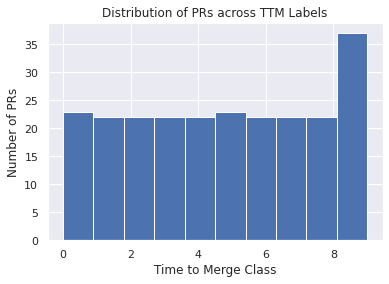

In [79]:
# visualize data points distribution across classes
feature_df["ttm_class"].hist()
plt.title("Distribution of PRs across TTM Labels")
plt.xlabel("Time to Merge Class")
plt.ylabel("Number of PRs")
plt.show()

From the above graph, we can see that data is fairly uniformly distributed across all classes. At the same time, the class definitions are also easily interpretable by human experts. So this seems like a good setup for our classification task.

Let's look at some pair-wise scatter plots of our data to see if there are any obvious correlations between our features. 

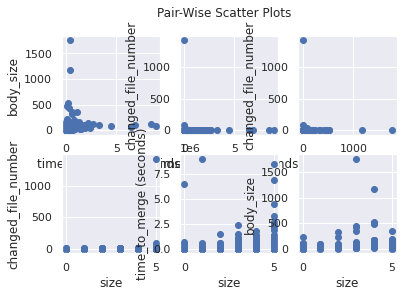

In [80]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
ax1.scatter(pr_df["time_to_merge"], pr_df["body_size"])
ax1.set(xlabel="time to merge (seconds)", ylabel="body_size")
ax2.scatter(pr_df["time_to_merge"], pr_df["changed_files_number"])
ax2.set(xlabel="time to merge (seconds)", ylabel="changed_file_number")
ax3.scatter(pr_df["body_size"], pr_df["changed_files_number"])
ax3.set(xlabel="body size", ylabel="changed_file_number")

ax4.scatter(pr_df["size"], pr_df["changed_files_number"])
ax4.set(xlabel="size", ylabel="changed_file_number")
ax5.scatter(pr_df["size"], pr_df["time_to_merge"])
ax5.set(xlabel="size", ylabel="time_to_merge (seconds)")
ax6.scatter(pr_df["size"], pr_df["body_size"])
ax6.set(xlabel="size", ylabel="body_size")

fig.suptitle("Pair-Wise Scatter Plots")
plt.show()

## Evaluating Feature Importances

### Categorical Features

First, lets try to determine what categorical featuers are powerful influencers for time to merge of a PR

In [81]:
# feature selection helper function
def select_features(x, y, func):
    fs = SelectKBest(score_func=func, k="all")
    fs.fit(x, y)
    x_fs = fs.transform(x)
    return x_fs, fs


selected_features = []

In [82]:
cat_features = [
    "size",
    "created_at_day",
    "created_at_month",
    "created_at_weekday",
    "created_at_hour",
    "ttm_class",
]

In [83]:
cat_df = feature_df[cat_features]

cat_df.head()

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,ttm_class
0,0,22,7,4,17,1
1,2,22,7,4,17,9
2,5,22,7,4,17,0
3,0,22,7,4,14,3
4,1,22,7,4,12,3


In [84]:
# split into input (x) and output (y) variables
X_inp = cat_df.drop(columns=["ttm_class"])
y = cat_df["ttm_class"]

In [85]:
# rank using mutual_info_classif
X_fs, fs = select_features(X_inp, y, mutual_info_classif)

In [86]:
for i in range(len(fs.scores_)):
    print("Feature %s: %f" % (X_inp.columns[i], fs.scores_[i]))

Feature size: 0.000000
Feature created_at_day: 0.066868
Feature created_at_month: 0.057712
Feature created_at_weekday: 0.123033
Feature created_at_hour: 0.012800


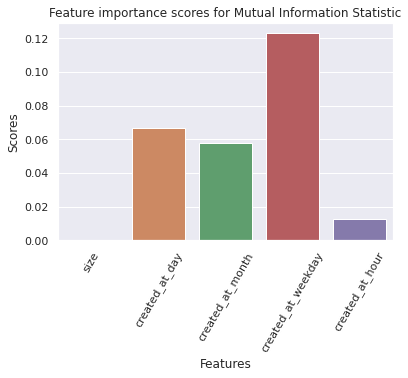

In [87]:
# visualize scores of all features
sns.barplot(x=X_inp.columns, y=fs.scores_)
plt.title("Feature importance scores for Mutual Information Statistic")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

In [88]:
# Lets get a list of the top 10 feature indices based on Mutual Info Stat feature scores
top_mis = fs.scores_.argsort()[-10:][::-1]

In [89]:
# rank using chi_sq
X_fs, fs = select_features(X_inp, y, chi2)

In [90]:
for i in range(len(fs.scores_)):
    print("Feature %s: %f" % (X_inp.columns[i], fs.scores_[i]))

Feature size: 34.292192
Feature created_at_day: 55.235422
Feature created_at_month: 21.460760
Feature created_at_weekday: 17.841107
Feature created_at_hour: 18.087208


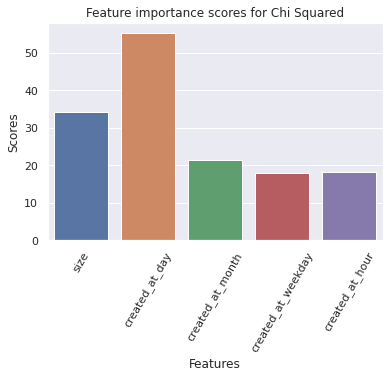

In [91]:
# visualize scores of all features
sns.barplot(x=X_inp.columns, y=fs.scores_)
plt.title("Feature importance scores for Chi Squared")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

In [92]:
# Lets get a list of the top 10 feature indices based on Chi Sq feature scores
top_chi2 = fs.scores_.argsort()[-10:][::-1]

Let's get a Union of the top 10 features derived from features based on both scores of both Mutual Info Statistic and Chi Squared

In [93]:
union = set(top_mis).union(set(top_chi2))
print(len(union))
union

5


{0, 1, 2, 3, 4}

In [94]:
selected_cat_features = [cat_features[i] for i in union]
selected_cat_features

['size',
 'created_at_day',
 'created_at_month',
 'created_at_weekday',
 'created_at_hour']

In [95]:
# update list of features to keep for training
selected_features += selected_cat_features

### Numerical Features

Now, lets try to determine what numerical featuers are powerful influencers for time to merge of a PR

In [96]:
numerical_features = [
    "changed_files_number",
    "body_size",
    "commits_number",
    "ttm_class",
]

In [97]:
numerical_df = feature_df[numerical_features]
numerical_df.head()

,changed_files_number,body_size,commits_number,ttm_class
0,1,0,1,1
1,2,237,1,9
2,4,2,1,0
3,9,6,2,3
4,4,2,1,3


In [98]:
# split into input features and target
X_inp = numerical_df.drop(columns=["ttm_class"])
y = numerical_df["ttm_class"]

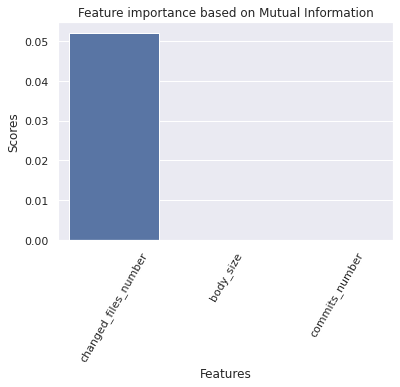

In [99]:
# create k best feature selector object based on mutual information
numerical_feats_mi, k_best_selector_mi = select_features(
    X_inp,
    y,
    partial(
        mutual_info_classif,
        discrete_features=False,
        random_state=42,
        n_neighbors=3,
    ),
)

# visualize the MI scores of all features
sns.barplot(x=X_inp.columns, y=k_best_selector_mi.scores_)
plt.title("Feature importance based on Mutual Information")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

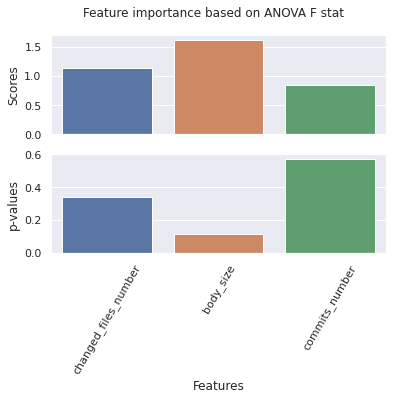

In [100]:
# create k best feature selector object based on anova f statistic
numerical_feats_f, k_best_selector_f = select_features(
    X_inp,
    y,
    f_classif,
)

# visualize the f stat scores and pvalues of all features
fig, axes = plt.subplots(2, 1, sharex=True)
fig.suptitle("Feature importance based on ANOVA F stat")
sns.barplot(x=X_inp.columns, y=k_best_selector_f.scores_, ax=axes[0])
sns.barplot(x=X_inp.columns, y=k_best_selector_f.pvalues_, ax=axes[1])
plt.xticks(rotation=60)
plt.xlabel("Features")
axes[0].set_ylabel("Scores")
axes[1].set_ylabel("p-values")
plt.show()

In [101]:
top_mi = k_best_selector_mi.scores_.argsort()[-3:][::-1]
top_anova = k_best_selector_f.scores_.argsort()[-3:][::-1]
union = set(top_mi).union(set(top_anova))
union

{0, 1, 2}

In [102]:
selected_num_features = [numerical_features[i] for i in union]
selected_num_features

['changed_files_number', 'body_size', 'commits_number']

In [103]:
# update list of features to keep for training
selected_features += selected_num_features

### Count Vector Type Features

Finally, lets determine the most important features from the count vector type columns.

In [104]:
# explode the list column so that there is 1 column representing frequency of each file type
filetype_df = pd.DataFrame(feature_df.changed_file_type_vec.to_list())
filetype_df.index = feature_df.index
filetype_df.columns = [f"filetype_{f}" for f in top_fileextensions]

In [105]:
# compute correlation with ttm
corr = filetype_df.corrwith(feature_df["ttm_class"])
corr.sort_values(ascending=False)

filetype_.lock                   0.187281
filetype_.sh                     0.092061
filetype_.pdf                    0.092061
filetype_.parquet                0.074998
filetype_Pipfile                 0.074819
filetype_.rst                    0.070308
filetype_.gz                     0.053947
filetype_.csv                    0.053947
filetype_environment             0.034394
filetype_.pipeline               0.030110
filetype_.toml                   0.005048
filetype_.txt                   -0.000998
filetype_.yml                   -0.015209
filetype_CODEOWNERS             -0.016705
filetype_.bat                   -0.016705
filetype_.ini                   -0.016705
filetype_.json                  -0.023476
filetype_env_example_workshop   -0.023675
filetype_.mdx                   -0.032710
filetype_OWNERS                 -0.037674
filetype_.yaml                  -0.063654
filetype_LICENSE                -0.069918
filetype_.py                    -0.089780
filetype_None                   -0

In [106]:
corr[corr.abs() > 0.01]

filetype_.png                   -0.103283
filetype_.ipynb                 -0.121503
filetype_.html                  -0.131692
filetype_.md                    -0.144870
filetype_.po                    -0.103717
filetype_.py                    -0.089780
filetype_.doctree               -0.103717
filetype_.yaml                  -0.063654
filetype_.js                    -0.128066
filetype_.lock                   0.187281
filetype_.css                   -0.126670
filetype_Pipfile                 0.074819
filetype_.svg                   -0.113571
filetype_.pipeline               0.030110
filetype_.mdx                   -0.032710
filetype_.yml                   -0.015209
filetype_environment             0.034394
filetype_.json                  -0.023476
filetype_OWNERS                 -0.037674
filetype_None                   -0.099302
filetype_.csv                    0.053947
filetype_.gz                     0.053947
filetype_.eot                   -0.103717
filetype_.ttf                   -0

In [107]:
# update list of features to keep for training
# take everything that has more than 0.01 correlation magnitude
filetype_keep_cols = corr[corr.abs() > 0.01].index.tolist()
selected_features += filetype_keep_cols

# only keep the relevant columns now
filetype_df = filetype_df[filetype_keep_cols]

In [108]:
filetype_keep_cols = [i[9:] for i in filetype_keep_cols]
filetype_keep_cols

['.png',
 '.ipynb',
 '.html',
 '.md',
 '.po',
 '.py',
 '.doctree',
 '.yaml',
 '.js',
 '.lock',
 '.css',
 'Pipfile',
 '.svg',
 '.pipeline',
 '.mdx',
 '.yml',
 'environment',
 '.json',
 'OWNERS',
 'None',
 '.csv',
 '.gz',
 '.eot',
 '.ttf',
 '.woff',
 '.woff2',
 '.rst',
 '.parquet',
 'env_example_workshop',
 '.map',
 'LICENSE',
 '.pickle',
 '.buildinfo',
 '.inv',
 '.pdf',
 '.sh',
 'CODEOWNERS',
 '.bat',
 '.ini']

In [109]:
filetype_keep_cols_df = pd.DataFrame(filetype_keep_cols, columns=["filetype"])

In [110]:
filetype_keep_cols_df

,filetype
0,.png
1,.ipynb
2,.html
3,.md
4,.po
5,.py
6,.doctree
7,.yaml
8,.js
9,.lock


In [111]:
FILETYPE_FEATURES_FILENAME = os.path.join(ORG + REPO + "FILETYPE.parquet")
FILETYPE_FEATURES_KEY = os.path.join(s3_input_data_path, ORG, REPO, "features")
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
cc.upload_to_ceph(
    filetype_keep_cols_df, FILETYPE_FEATURES_KEY, FILETYPE_FEATURES_FILENAME
)

{'ResponseMetadata': {'RequestId': 'tx00000000000000058f6c2-0062def2bf-2f12b8-ocs-storagecluster-cephobjectstore',
  'HostId': '',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-length': '0',
   'etag': '"4a82758752ac4879846620593edeaeb6"',
   'accept-ranges': 'bytes',
   'x-amz-request-id': 'tx00000000000000058f6c2-0062def2bf-2f12b8-ocs-storagecluster-cephobjectstore',
   'date': 'Mon, 25 Jul 2022 19:45:03 GMT',
   'set-cookie': '8b0897a8f8b6f7f420db49fdef9a84b8=8a437562f974804482699da2db9fb9f7; path=/; HttpOnly; Secure; SameSite=None'},
  'RetryAttempts': 0},
 'ETag': '"4a82758752ac4879846620593edeaeb6"'}

In [112]:
# explode the list column so that there is 1 column representing frequency of each word
title_wordcount_df = pd.DataFrame(feature_df.title_word_counts_vec.to_list())

title_wordcount_df.index = feature_df.index
title_wordcount_df.columns = [f"title_wordcount_{w}" for w in unique_words]

In [113]:
# compute correlation with ttm
corr = title_wordcount_df.corrwith(feature_df["ttm_class"])
corr = corr.dropna()
corr.sort_values(ascending=False)

title_wordcount_log          0.178185
title_wordcount_point        0.174356
title_wordcount_optimal      0.174356
title_wordcount_stopping     0.174356
title_wordcount_automatic    0.170328
                               ...   
title_wordcount_fixes       -0.146990
title_wordcount_broken      -0.155184
title_wordcount_links       -0.163795
title_wordcount_file        -0.186873
title_wordcount_fix         -0.240437
Length: 436, dtype: float64

In [114]:
corr[corr.abs() > 0.04]

title_wordcount_access         0.115056
title_wordcount_across        -0.060211
title_wordcount_add            0.073496
title_wordcount_adds           0.053398
title_wordcount_adjustments    0.092061
                                 ...   
title_wordcount_website       -0.054503
title_wordcount_wip            0.119625
title_wordcount_workflows      0.092061
title_wordcount_yaml          -0.146990
title_wordcount_⬆️             0.048554
Length: 264, dtype: float64

In [115]:
# update list of features to keep for training
# take everything that has more than 0.01 correlation magnitude
title_word_keep_cols = corr[corr.abs() > 0.04].index.tolist()
selected_features += title_word_keep_cols

title_wordcount_df = title_wordcount_df[title_word_keep_cols]

In [116]:
title_word_keep_cols = [i[16:] for i in title_word_keep_cols]
title_word_keep_cols

['access',
 'across',
 'add',
 'adds',
 'adjustments',
 'aicoe',
 'analysis',
 'append',
 'argo',
 'attempt',
 'automatic',
 'automation',
 'base',
 'beyond',
 'bits',
 'black',
 'black_nb',
 'bleach',
 'broken',
 'bs4',
 'bugfix',
 'build_pass_failure',
 'bump',
 'buspark',
 'calculate',
 'catch',
 'cell',
 'changed',
 'changes',
 'chapters',
 'classification',
 'classifier',
 'classifiers',
 'cleanup',
 'clustering',
 'colon',
 'config',
 'conflict',
 'conflicts',
 'content',
 'correlation_failures',
 'create',
 'csv',
 'custom',
 'cutom',
 'dashboard',
 'dashboards',
 'data',
 'dependencies',
 'depth',
 'description',
 'detection',
 'dev',
 'df',
 'dir',
 'directory',
 'discrepancy',
 'distribtion',
 'distribution',
 'docs',
 'documented',
 'due',
 'duration',
 'ec506',
 'eda',
 'edges',
 'editable',
 'elyra',
 'empty',
 'encoding',
 'endpoint',
 'engg',
 'engineering',
 'environment',
 'existing',
 'exploration',
 'exploring',
 'extract',
 'failing',
 'failure',
 'failure_type_clas

In [117]:
title_word_keep_cols_df = pd.DataFrame(title_word_keep_cols, columns=["title"])

In [118]:
title_word_keep_cols_df

,title
0,access
1,across
2,add
3,adds
4,adjustments
...,...
259,website
260,wip
261,workflows
262,yaml


In [119]:
TITLE_FEATURES_FILENAME = os.path.join(ORG + REPO + "titlewords.parquet")
TITLE_FEATURES_KEY = os.path.join(s3_input_data_path, ORG, REPO, "features")
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
cc.upload_to_ceph(title_word_keep_cols_df, TITLE_FEATURES_KEY, TITLE_FEATURES_FILENAME)

{'ResponseMetadata': {'RequestId': 'tx00000000000000058f6c3-0062def2c2-2f12b8-ocs-storagecluster-cephobjectstore',
  'HostId': '',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-length': '0',
   'etag': '"2939e5e850b4fbf05299c75921ac23e3"',
   'accept-ranges': 'bytes',
   'x-amz-request-id': 'tx00000000000000058f6c3-0062def2c2-2f12b8-ocs-storagecluster-cephobjectstore',
   'date': 'Mon, 25 Jul 2022 19:45:07 GMT',
   'set-cookie': '8b0897a8f8b6f7f420db49fdef9a84b8=8a437562f974804482699da2db9fb9f7; path=/; HttpOnly; Secure; SameSite=None'},
  'RetryAttempts': 0},
 'ETag': '"2939e5e850b4fbf05299c75921ac23e3"'}

Using various feature importance scores such as chi-squared, mutual information statistic, correlation values, we have selected the most relevant features amongst all of our features. 

In [120]:
selected_features

['size',
 'created_at_day',
 'created_at_month',
 'created_at_weekday',
 'created_at_hour',
 'changed_files_number',
 'body_size',
 'commits_number',
 'filetype_.png',
 'filetype_.ipynb',
 'filetype_.html',
 'filetype_.md',
 'filetype_.po',
 'filetype_.py',
 'filetype_.doctree',
 'filetype_.yaml',
 'filetype_.js',
 'filetype_.lock',
 'filetype_.css',
 'filetype_Pipfile',
 'filetype_.svg',
 'filetype_.pipeline',
 'filetype_.mdx',
 'filetype_.yml',
 'filetype_environment',
 'filetype_.json',
 'filetype_OWNERS',
 'filetype_None',
 'filetype_.csv',
 'filetype_.gz',
 'filetype_.eot',
 'filetype_.ttf',
 'filetype_.woff',
 'filetype_.woff2',
 'filetype_.rst',
 'filetype_.parquet',
 'filetype_env_example_workshop',
 'filetype_.map',
 'filetype_LICENSE',
 'filetype_.pickle',
 'filetype_.buildinfo',
 'filetype_.inv',
 'filetype_.pdf',
 'filetype_.sh',
 'filetype_CODEOWNERS',
 'filetype_.bat',
 'filetype_.ini',
 'title_wordcount_access',
 'title_wordcount_across',
 'title_wordcount_add',
 'title_

## Save Feature Engineered Dataset

In [121]:
# join all types of features
ttm_dataset = pd.concat(
    [feature_df, filetype_df, title_wordcount_df], axis=1, ignore_index=False
)

# keep only the selected features and the prediction label
ttm_dataset = ttm_dataset[selected_features + ["ttm_class", "time_to_merge"]]

ttm_dataset.head()

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_files_number,body_size,commits_number,filetype_.png,filetype_.ipynb,...,title_wordcount_video,title_wordcount_visualization,title_wordcount_walkthrough,title_wordcount_website,title_wordcount_wip,title_wordcount_workflows,title_wordcount_yaml,title_wordcount_⬆️,ttm_class,time_to_merge
0,0,22,7,4,17,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,3949.0
1,2,22,7,4,17,2,237,1,0,0,...,0,0,0,0,0,0,0,0,9,NaN
2,5,22,7,4,17,4,2,1,0,4,...,0,0,0,0,0,0,0,0,0,1054.0
3,0,22,7,4,14,9,6,2,8,0,...,0,0,0,0,0,0,0,0,3,13938.0
4,1,22,7,4,12,4,2,1,3,0,...,0,0,0,0,0,0,0,0,3,11264.0


In [122]:
ttm_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Columns: 313 entries, size to time_to_merge
dtypes: float64(1), int64(312)
memory usage: 579.7 KB


## Save results to Ceph or locally

Using the helper function to save the data frame in a parquet format on the Ceph bucket if we are running in automation, and locally if not.

In [123]:
TTM_DATASET_PATH = os.path.join(s3_input_data_path, ORG, REPO)

In [124]:
## Sanity check to see if the dataset is the same

if REMOTE:
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    try:
        cc.upload_to_ceph(
            ttm_dataset,
            TTM_DATASET_PATH,
            "ttm_feature_engineered_dataset.parquet",
        )
    except ValueError as ve:
        print(ve)
        print("Files already uploaded to S3")

else:
    save_to_disk(
        ttm_dataset,
        local_output_data_path,
        "ttm_dataset.parquet",
    )

### Check contents of the S3 bucket so far

In [125]:
# check all raw data files in s3
bucket = cc.s3_resource.Bucket(s3_bucket)
objects = [i for i in bucket.objects.all() if s3_input_data_path + "/" in i.key]
sorted(objects, key=lambda x: x.key)

[s3.ObjectSummary(bucket_name='aiops-tools-workshop-2', key='oindrillac/aicoe-aiops/ocp-ci-analysis/features/aicoe-aiopsocp-ci-analysisFILETYPE.parquet'),
 s3.ObjectSummary(bucket_name='aiops-tools-workshop-2', key='oindrillac/aicoe-aiops/ocp-ci-analysis/features/aicoe-aiopsocp-ci-analysistitlewords.parquet'),
 s3.ObjectSummary(bucket_name='aiops-tools-workshop-2', key='oindrillac/aicoe-aiops/ocp-ci-analysis/sql/'),
 s3.ObjectSummary(bucket_name='aiops-tools-workshop-2', key='oindrillac/aicoe-aiops/ocp-ci-analysis/sql/aicoe-aiopsocp-ci-analysisprs.parquet'),
 s3.ObjectSummary(bucket_name='aiops-tools-workshop-2', key='oindrillac/aicoe-aiops/ocp-ci-analysis/test-data/X_test.parquet'),
 s3.ObjectSummary(bucket_name='aiops-tools-workshop-2', key='oindrillac/aicoe-aiops/ocp-ci-analysis/test-data/y_test.parquet'),
 s3.ObjectSummary(bucket_name='aiops-tools-workshop-2', key='oindrillac/aicoe-aiops/ocp-ci-analysis/ttm-model/model.joblib'),
 s3.ObjectSummary(bucket_name='aiops-tools-workshop-2

# Conclusion

This notebook walked through how to access saved raw Pull Requests data from the previous data collection notebook and we engineered some possible features which can be used to predict time to merge of a PR. 

The features we engineered are as following:

- time_to_merge: time taken to merge a PR in seconds, this is feature we will try to predict
- changed_files_number: integer indicating the number of files changed, this is an available column
- body_size: integer indicating the number of words in the body of the PR, derived from body
- size: integer corresponding to a categorical label generated by GitHub which summarizes the size of the changes made to the code base 
- title_word_counts_vec: vector or list indicating how many times each word appeared in the title
- created_at_day: categorical variable indicating the day of month the PR has been created, derived from created_at
- created_at_month: categorical variable indicating the month of the year that the PR has been created, derived from created_at
- created_at_weekday: categorical variable indicating the day of the week the PR has been created, derived from created_at
- created_at_hour: categorical variable indicating the hour of the day the PR has been created, derived from created_at
- commits_number: integer indicating the number of commits in the PR
- changed_file_type_vec:  vector or list consisting of number of files changed for the top 100 most frequently occurring data types, derived from changed_files


# Next Step

In the next [notebook](./03_model_training.ipynb), we will train a classifier to predict time to merge of a PR using the features.